In [1]:
pip install pandas numpy seaborn matplotlib tensorflow sklearn xgboost networkx

     |████████████████████████████████| 9.5 MB 5.0 MB/s eta 0:00:01
     |████████████████████████████████| 285 kB 29.4 MB/s eta 0:00:01
     |████████████████████████████████| 11.5 MB 26.4 MB/s eta 0:00:01
     |████████████████████████████████| 166.7 MB 29.3 MB/s eta 0:00:01     |████████████████████████████    | 146.0 MB 28.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 5.2 MB/s eta 0:00:01
     |████████████████████████████████| 25.9 MB 28.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 4.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 30.9 MB/s eta 0:00:01
     |████████████████████████████████| 22.2 MB 28.3 MB/s eta 0:00:01
     |████████████████████████████████| 303 kB 29.9 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=49227ad58ccfdcb94b07dea94ca7f2a44df81c36c953a9be42669aec37a70df1
  Stored in directory: /root/.cache/pip/wheels/23/9d/42/5ec745cbbb17517000a53cecc49d6

In [2]:
# import libraries
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as math
import time
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [14,14]

In [3]:
# load the data
df = pd.read_csv('netflix_titles.csv')
# convert to datetime
df['date_added'] = pd.to_datetime(df['date_added'])
df['year'] = df['date_added'].dt.year
df['month'] = df['date_added'].dt.month
df['day'] = df['date_added'].dt.day
#convert columns "director, listed_in, cast and country" in columns that contain a real list
# apply strip function on the elements
# if NaN, the new column contains an empty list []

df['directors'] = df['director'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['categories'] = df['listed_in'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['actors'] = df['cast'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['countries'] = df['country'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])

print(df.shape)
df

(7787, 19)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year,month,day,directors,categories,actors,countries
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020.0,8.0,14.0,[],"[International TV Shows, TV Dramas, TV Sci-Fi ...","[João Miguel, Bianca Comparato, Michel Gomes, ...",[Brazil]
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016.0,12.0,23.0,[Jorge Michel Grau],"[Dramas, International Movies]","[Demián Bichir, Héctor Bonilla, Oscar Serrano,...",[Mexico]
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",2018.0,12.0,20.0,[Gilbert Chan],"[Horror Movies, International Movies]","[Tedd Chan, Stella Chung, Henley Hii, Lawrence...",[Singapore]
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017-11-16,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",2017.0,11.0,16.0,[Shane Acker],"[Action & Adventure, Independent Movies, Sci-F...","[Elijah Wood, John C. Reilly, Jennifer Connell...",[United States]
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,2020.0,1.0,1.0,[Robert Luketic],[Dramas],"[Jim Sturgess, Kevin Spacey, Kate Bosworth, Aa...",[United States]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7782,s7783,Movie,Zozo,Josef Fares,"Imad Creidi, Antoinette Turk, Elias Gergi, Car...","Sweden, Czech Republic, United Kingdom, Denmar...",2020-10-19,2005,TV-MA,99 min,"Dramas, International Movies",When Lebanon's Civil War deprives Zozo of his ...,2020.0,10.0,19.0,[Josef Fares],"[Dramas, International Movies]","[Imad Creidi, Antoinette Turk, Elias Gergi, Ca...","[Sweden, Czech Republic, United Kingdom, Denma..."
7783,s7784,Movie,Zubaan,Mozez Singh,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...",India,2019-03-02,2015,TV-14,111 min,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...,2019.0,3.0,2.0,[Mozez Singh],"[Dramas, International Movies, Music & Musicals]","[Vicky Kaushal, Sarah-Jane Dias, Raaghav Chana...",[India]
7784,s7785,Movie,Zulu Man in Japan,NaN,Nasty C,NaN,2020-09-25,2019,TV-MA,44 min,"Documentaries, International Movies, Music & M...","In this documentary, South African rapper Nast...",2020.0,9.0,25.0,[],"[Documentaries, International Movies, Music & ...",[Nasty C],[]
7785,s7786,TV Show,Zumbo's Just Desserts,NaN,"Adriano Zumbo, Rachel Khoo",Australia,2020-10-31,2019,TV-PG,1 Season,"International TV Shows, Reality TV",Dessert wizard Adriano Zumbo looks for the nex...,2020.0,10.0,31.0,[],"[International TV Shows, Reality TV]","[Adriano Zumbo, Rachel Khoo]",[Australia]


## KMeans clustering with TF-IDF

In [4]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

# Build the tfidf matrix with the descriptions
text_content = df['description']
vector = TfidfVectorizer(max_df=0.4,           # drop words that occur in more than X percent of documents
                        min_df = 1,       # only use words that appear at least X times
                        stop_words='english', # remove stop words
                        lowercase = True,     # Convert everything to lower case
                        use_idf = True,       # Use idf
                        norm = u'l2',         # l2 normalization
                        smooth_idf = True     # prevents dive-by-zero errors
                        )

tfidf = vector.fit_transform(text_content)

# Clustering  Kmeans
k = 200
kmeans = MiniBatchKMeans(n_clusters = k)
kmeans.fit(tfidf)
centers = kmeans.cluster_centers_.argsort()[:,::-1]
terms = vector.get_feature_names()

# print the centers of the clusters
for i in range(0,k):
     word_list=[]
     print("cluster%d:"% i)
     for j in centers[i,:10]:
         word_list.append(terms[j])
     print(word_list) 
    
request_transform = vector.transform(df['description'])
# new column cluster based on the description
df['cluster'] = kmeans.predict(request_transform) 

df['cluster'].value_counts().head()

cluster0:
['backstabbing', 'liver', 'consume', 'blackmail', 'costs', 'patriarch', 'dysfunctional', 'compete', 'revenge', 'wealthy']
cluster1:
['campbell', 'tia', 'tamera', 'landry', 'blending', 'personalities', '14', 'separated', 'twin', 'birth']
cluster2:
['stinginess', 'disliked', 'windfall', 'television', 'channel', 'samir', 'receives', 'launches', 'haunts', 'bridge']
cluster3:
['tutored', 'reconnecting', '30', 'traditional', 'crush', 'taken', 'path', 'year', 'high', 'old']
cluster4:
['mounting', 'closing', 'jeweler', 'collectors', 'debts', 'angry', 'staying', 'afloat', 'risks', 'alive']
cluster5:
['ended', 'avenge', 'framed', 'gangster', 'officer', 'deadly', 'dangerous', 'father', 'small', 'police']
cluster6:
['albinos', 'advocacy', 'waged', 'behalf', 'groups', 'health', 'details', 'african', 'chronicles', 'problems']
cluster7:
['afonso', 'padilha', 'digs', 'beginnings', 'dives', 'brazilian', 'humble', 'hilarious', 'comedian', 'childhood']
cluster8:
['femicides', 'bogotá', 'origins

93     7430
96       67
18       13
90        9
113       7
Name: cluster, dtype: int64

In [5]:
tfidf

<7787x17905 sparse matrix of type '<class 'numpy.float64'>'
	with 107187 stored elements in Compressed Sparse Row format>

In [6]:
# Find similar : get the top_n movies with description similar to the target description 
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n] 

## Load the Graph

In [7]:
G = nx.Graph(label='Movie')
start_time = time.time()
for i, rowi in df.iterrows():
    if (i%1000==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))
    G.add_node(rowi['title'],key=rowi['show_id'],label='MOVIE',mtype=rowi['type'],rating=rowi['rating'])

# G.add_node(rowi['cluster'],label='CLUSTER')
# G.add_edge(rowi['title'], rowi['cluster'],, label='DESCRIPTION')
    for element in rowi['actors']:
        G.add_node(element,label='PERSON')
        G.add_edge(rowi['title'], element, label='ACTED_IN')
    for element in rowi['categories']:
        G.add_node(element,label="CAT")
        G.add_edge(rowi['title'], element, label="CAT_IN")
    for element in rowi['directors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="DIRECTED")
    for element in rowi['countries']:
        G.add_node(element,label="COU")
        G.add_edge(rowi['title'], element, label="COU_IN")
        
    indices = find_similar(tfidf, i, top_n = 5)
    snode="Sim("+rowi['title'][:15].strip()+")"
    G.add_node(snode, label='SIMILAR')
    G.add_edge(rowi['title'], snode, label='SIMILARITY')
    for element in indices:
        G.add_edge(snode, df['title'].loc[element], label='SIMILARITY')
print(" finish -- {} seconds --".format(time.time() - start_time))

 iter 0 -- 0.04230189323425293 seconds --
 iter 1000 -- 6.375297546386719 seconds --
 iter 2000 -- 12.704338550567627 seconds --
 iter 3000 -- 19.058361530303955 seconds --
 iter 4000 -- 25.42457342147827 seconds --
 iter 5000 -- 31.707958459854126 seconds --
 iter 6000 -- 38.03776478767395 seconds --
 iter 7000 -- 44.314385175704956 seconds --
 finish -- 49.30840754508972 seconds --


In [8]:
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):
            sub_graph.add(e)
    return list(sub_graph)

def draw_sub_graph(sub_graph):
    subgraph = G.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        if G.nodes[e]['label'] == 'MOVIE':
            colors.append('blue')
        elif G.nodes[e]['label'] == 'PERSON':
            colors.append('red')
        elif G.nodes[e]['label']=="CAT":
            colors.append('green')
        elif G.nodes[e]['label']=="COU":
            colors.append('yellow')
        elif G.nodes[e]['label']=="SIMILAR":
            colors.append('orange')    
        elif G.nodes[e]['label']=="CLUSTER":
            colors.append('orange')
            
    nx.draw(subgraph, with_labels=True, font_weight='bold', node_color=colors)
    plt.show()

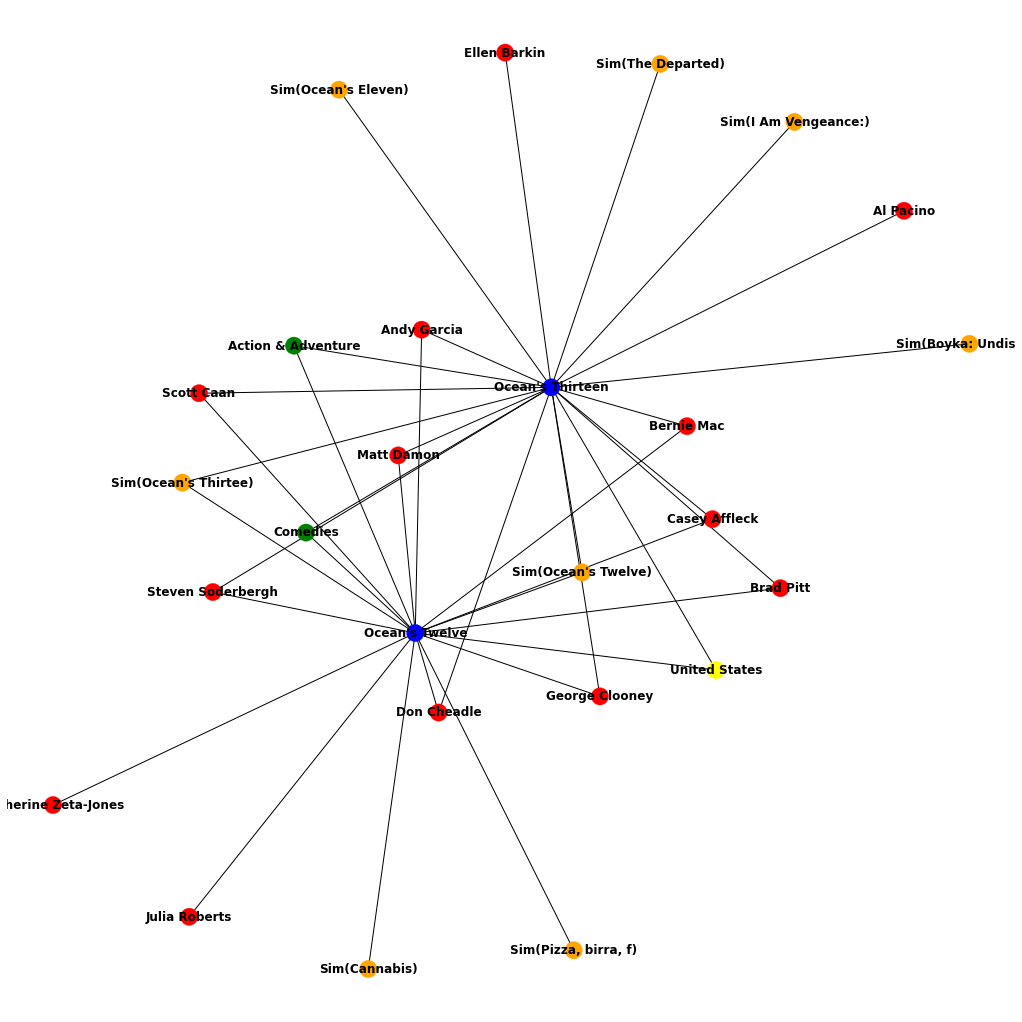

In [9]:
list_in=["Ocean's Twelve","Ocean's Thirteen"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

## Recommendation System

In [10]:
def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2==root:
                continue
            if G.nodes[e2]['label']=='MOVIE':
                commons = commons_dict.get(e2)
                if commons==None:
                    commons_dict.update({e2 : [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2 : commons})
    movies=[]
    weight = []
    for key, values in commons_dict.items():
        w=0.0
        for e in values:
            w=w+1/math.log(G.degree(e))
        movies.append(key)
        weight.append(w)
    
    result = pd.Series(data=np.array(weight),index=movies)
    result.sort_values(inplace=True,ascending=False)
    return result

In [11]:
#Test it
result = get_recommendation("Ocean's Twelve")
result2 = get_recommendation("Ocean's Thirteen")
result3 = get_recommendation("The Devil Inside")
result4 = get_recommendation("Stranger Things")
print("*"*40+"\n Recommendation for 'Ocean's Twelve'\n"+"*"*40)
print(result.head())
print("*"*40+"\n Recommendation for 'Ocean's Thirteen'\n"+"*"*40)
print(result2.head())
print("*"*40+"\n Recommendation for 'Belmonte'\n"+"*"*40)
print(result3.head())
print("*"*40+"\n Recommendation for 'Stranger Things'\n"+"*"*40)
print(result4.head())

****************************************
 Recommendation for 'Ocean's Twelve'
****************************************
Ocean's Thirteen    7.033613
Ocean's Eleven      1.528732
The Informant!      1.252955
Babel               1.162454
Cannabis            1.116221
dtype: float64
****************************************
 Recommendation for 'Ocean's Thirteen'
****************************************
Ocean's Twelve       7.033613
The Departed         2.232071
Ocean's Eleven       2.086843
Brooklyn's Finest    1.467979
Boyka: Undisputed    1.391627
dtype: float64
****************************************
 Recommendation for 'Belmonte'
****************************************
The Boy                                  1.901648
The Devil and Father Amorth              1.413791
Making a Murderer                        1.239666
Belief: The Possession of Janet Moses    1.116221
I Am Vengeance                           1.116221
dtype: float64
****************************************
 Recommendation 

### Draw top recommendations, to see the common nodes

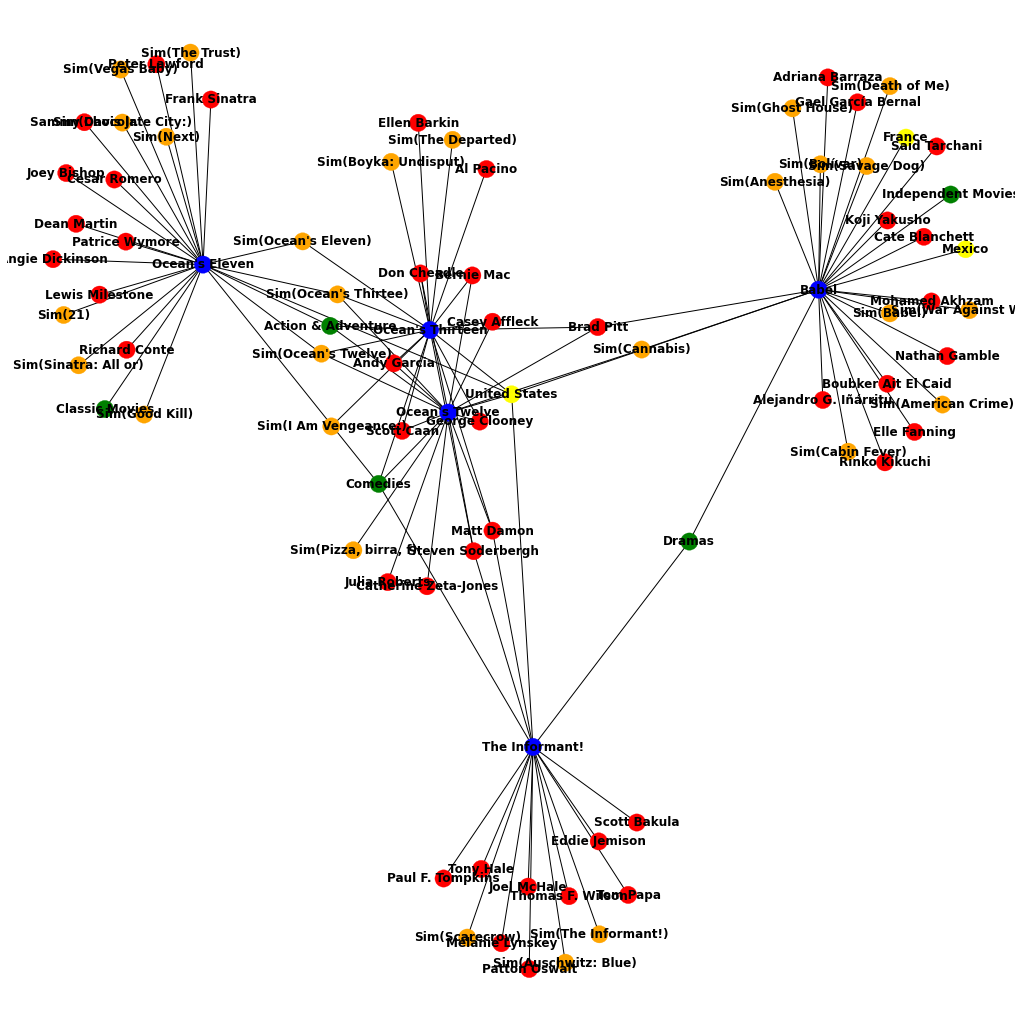

In [12]:
reco=list(result.index[:4].values)
reco.extend(["Ocean's Twelve"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)

In [25]:
def conclude_results(title):
    result = get_recommendation(title)
    print("*"*40+"\n Recommendation for {} \n".format(title)+"*"*40)
    print(result.head())
    
    reco=list(result.index[:4].values)
    reco.extend([title])
    sub_graph = get_all_adj_nodes(reco)
    draw_sub_graph(sub_graph)

In [23]:
df.title.sample(50)

4851                                      Phullu
5705                          Someone Has to Die
5971                       Tales From the Hood 2
2828                          Hotel Transylvania
4717                                           P
3762                                 Love Jacked
6635                              The Main Event
3456                                      Kristy
6740                               The Paramedic
5165                                     Requiem
2771    Holiday Home Makeover with Mr. Christmas
5101                                     Rapture
3119                Jamtara - Sabka Number Ayega
1064                         Bountiful Blessings
4168                                Molly's Game
6156                             The Book of Sun
3030                           Into the Badlands
2344                  Game Over (Telugu Version)
188                            A House of Blocks
5148         ReMastered: Devil at the Crossroads
6779                

****************************************
 Recommendation for Ocean's Eleven 
****************************************
Chocolate City: Vegas Strip    4.588330
Frank & Lola                   4.030219
Next                           3.065959
Ocean's Thirteen               2.086843
Mutiny on the Bounty           1.933863
dtype: float64


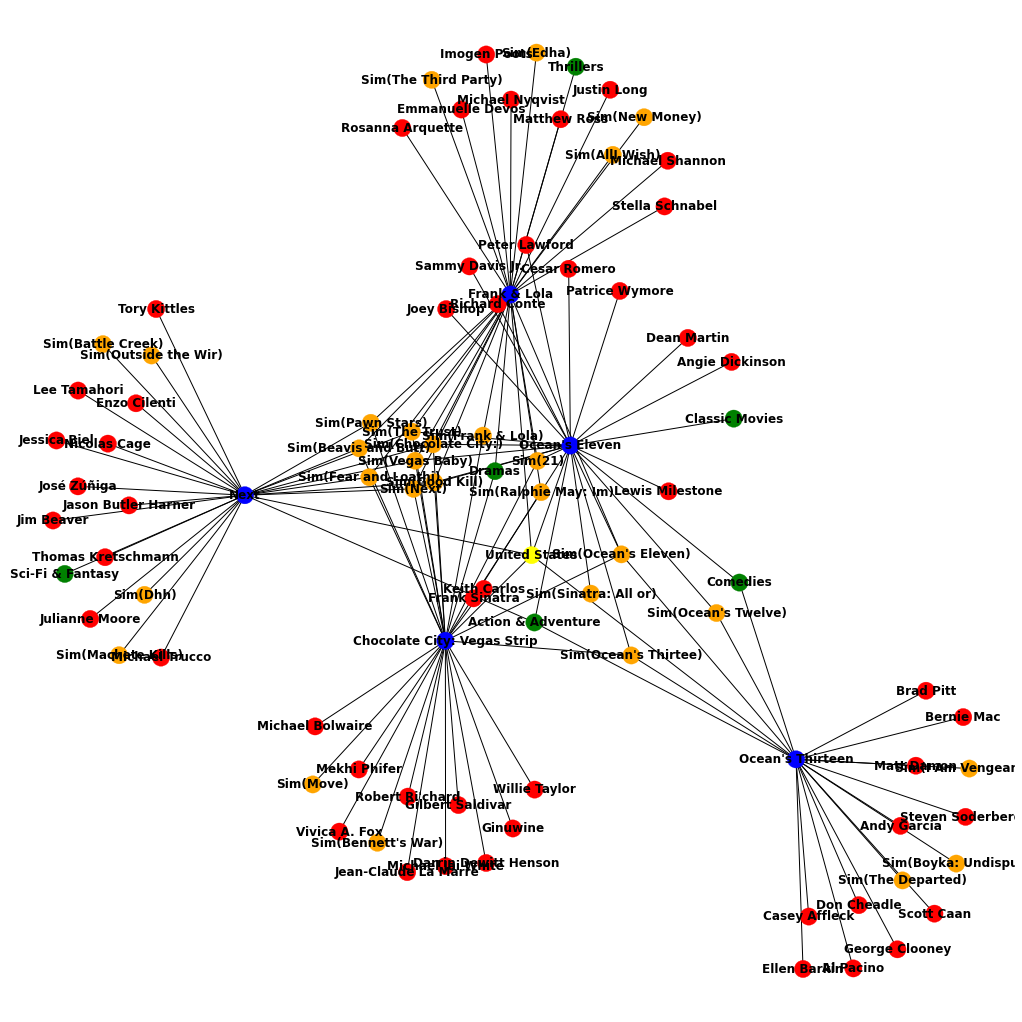

In [30]:
conclude_results('Ocean\'s Eleven')